<a href="https://colab.research.google.com/github/kenol7/DeepLearningEndcorder/blob/main/MuhammadAinolYakin_3090.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset downloaded to: /kaggle/input/sports-classification
Copied 120 bowling images
Copied 142 volleyball images
Copied 131 tennis images
Copied 166 rugby images


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 1, 1, 128, 128])) that is different to the input size (torch.Size([16, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([15, 1, 1, 128, 128])) that is different to the input size (torch.Size([15, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.1175
Epoch 1 - PSNR: 16.81, SSIM: 0.3002
Epoch 2, Loss: 0.0993
Epoch 2 - PSNR: 17.05, SSIM: 0.3137
Epoch 3, Loss: 0.0973
Epoch 3 - PSNR: 18.50, SSIM: 0.3455
Epoch 4, Loss: 0.0961
Epoch 4 - PSNR: 18.60, SSIM: 0.3479
Epoch 5, Loss: 0.0951
Epoch 5 - PSNR: 18.02, SSIM: 0.3538
Epoch 6, Loss: 0.0944
Epoch 6 - PSNR: 18.17, SSIM: 0.3740
Epoch 7, Loss: 0.0944
Epoch 7 - PSNR: 18.23, SSIM: 0.3444
Epoch 8, Loss: 0.0943
Epoch 8 - PSNR: 18.75, SSIM: 0.3729
Epoch 9, Loss: 0.0939
Epoch 9 - PSNR: 18.36, SSIM: 0.3813
Epoch 10, Loss: 0.0937
Epoch 10 - PSNR: 19.42, SSIM: 0.3852
Epoch 11, Loss: 0.0938
Epoch 11 - PSNR: 18.70, SSIM: 0.3783
Epoch 12, Loss: 0.0937
Epoch 12 - PSNR: 18.73, SSIM: 0.3784
Epoch 13, Loss: 0.0934
Epoch 13 - PSNR: 17.98, SSIM: 0.3734
Epoch 14, Loss: 0.0934
Epoch 14 - PSNR: 19.44, SSIM: 0.3891
Epoch 15, Loss: 0.0932
Epoch 15 - PSNR: 18.37, SSIM: 0.3718


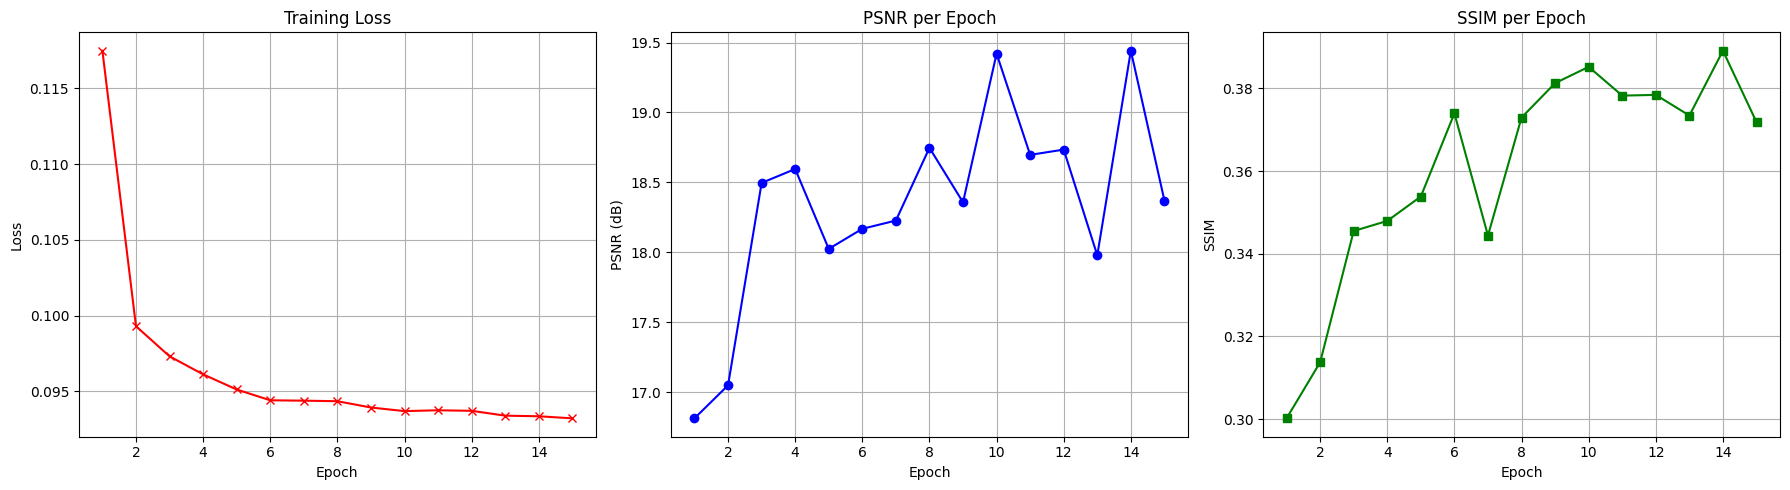

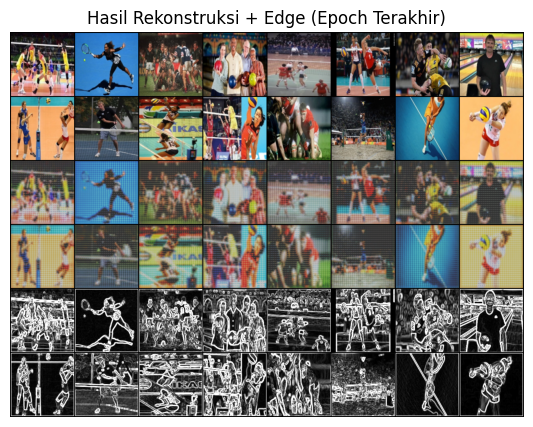

Training selesai!


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import kagglehub
import os
import shutil
from PIL import Image
import numpy as np
import math
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# 1. Download dataset
path = kagglehub.dataset_download("gpiosenka/sports-classification")
print("Dataset downloaded to:", path)

# 2. Ekstrak kategori yang dibutuhkan
categories = ['bowling', 'volleyball', 'tennis', 'rugby']
input_dir = "sports_balls"
os.makedirs(input_dir, exist_ok=True)

for category in categories:
    src_dir = os.path.join(path, "train", category)
    dst_dir = os.path.join(input_dir, category)
    shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)
    print(f"Copied {len(os.listdir(src_dir))} {category} images")

# 3. Dataset class
class SportsBallDataset(Dataset):
    def __init__(self, root_dir, transform=None, edge_enhance=True):
        self.root_dir = root_dir
        self.transform = transform
        self.edge_enhance = edge_enhance
        self.image_paths = []
        for category in os.listdir(root_dir):
            category_path = os.path.join(root_dir, category)
            for img_name in os.listdir(category_path):
                self.image_paths.append(os.path.join(category_path, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.edge_enhance:
            edge_map = self.get_edge_map(image)
            return image, edge_map
        return image, image

    def get_edge_map(self, image_tensor):
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)
        elif image_tensor.dim() != 4:
            raise ValueError(f"Expected 3D or 4D input, got {image_tensor.shape}")
        gray = image_tensor.mean(dim=1, keepdim=True)
        sobel_x = torch.tensor([[[-1., 0., 1.],
                                 [-2., 0., 2.],
                                 [-1., 0., 1.]]], dtype=torch.float32).expand(1, 1, 3, 3)
        sobel_y = torch.tensor([[[-1., -2., -1.],
                                 [ 0.,  0.,  0.],
                                 [ 1.,  2.,  1.]]], dtype=torch.float32).expand(1, 1, 3, 3)
        sobel_x = sobel_x.to(image_tensor.device)
        sobel_y = sobel_y.to(image_tensor.device)
        edges_x = F.conv2d(gray, sobel_x, padding=1)
        edges_y = F.conv2d(gray, sobel_y, padding=1)
        edge_map = torch.sqrt(edges_x ** 2 + edges_y ** 2)
        return edge_map

# 4. Transformasi & DataLoader
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
dataset = SportsBallDataset(input_dir, transform=transform, edge_enhance=True)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 5. Autoencoder
class EdgeAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )
        self.edge_path = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x = self.dec1(x2)
        x = self.dec2(x)
        x = self.dec3(x)
        with torch.no_grad():
            gray = 0.2989 * x[:,0] + 0.5870 * x[:,1] + 0.1140 * x[:,2]
            edges = self.edge_path(gray.unsqueeze(1))
        enhanced = x * 0.6 + edges.repeat(1,3,1,1) * 0.4
        return enhanced

# 6. PSNR & SSIM Calculation
def psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return 100
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def ssim_score(img1, img2):
    img1 = img1.permute(0, 2, 3, 1).cpu().numpy()
    img2 = img2.permute(0, 2, 3, 1).cpu().numpy()
    return np.mean([ssim(img1[i], img2[i], win_size=3, channel_axis=-1, data_range=1) for i in range(img1.shape[0])])

# 7. Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EdgeAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

psnr_history = []
ssim_history = []
loss_history = []
epoch_checkpoints = []

os.makedirs("results", exist_ok=True)

for epoch in range(15):
    model.train()
    running_loss = 0.0
    for inputs, edges in loader:
        inputs = inputs.to(device)
        edges = edges.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        recon_loss = criterion(outputs, inputs)
        edge_loss = criterion(dataset.get_edge_map(outputs), edges)
        loss = recon_loss + 0.3 * edge_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(loader)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    with torch.no_grad():
        test_inputs, test_edges = next(iter(loader))
        test_inputs = test_inputs.to(device)
        test_edges = test_edges.to(device)
        outputs = model(test_inputs)
        test_edges = test_edges.squeeze(1)
        comparison = torch.cat([
            test_inputs.cpu(),
            outputs.cpu(),
            test_edges.repeat(1, 3, 1, 1).cpu()
        ])
        save_image(comparison, f'results/comparison_epoch_{epoch}.png', nrow=8)
        psnr_value = psnr(test_inputs, outputs)
        ssim_value = ssim_score(test_inputs, outputs)
        psnr_history.append(psnr_value.item())
        ssim_history.append(ssim_value)
        epoch_checkpoints.append(epoch + 1)
        print(f"Epoch {epoch+1} - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")

# 8. Visualisasi metrik & hasil akhir
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epoch_checkpoints, loss_history, marker='x', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epoch_checkpoints, psnr_history, marker='o', color='blue')
plt.title("PSNR per Epoch")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epoch_checkpoints, ssim_history, marker='s', color='green')
plt.title("SSIM per Epoch")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.grid(True)

plt.tight_layout()
plt.show()

# 9. Tampilkan hasil rekonstruksi akhir
from PIL import Image

last_image_path = f"results/comparison_epoch_{epoch}.png"
img = Image.open(last_image_path)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')
plt.title("Hasil Rekonstruksi + Edge (Epoch Terakhir)")
plt.show()

print("Training selesai!")
